In [1]:
!pwd

/home/airg/rbalogun/ftwfieldmapper


In [2]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

# Load checkpoint
checkpoint = torch.load("model_weights/ftw-3class-full_unet-efficientnetb3_rgbnir_1ba4e1bd.pth")

# Remove _conv_stem.weight
checkpoint.pop("encoder._conv_stem.weight", None)

model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=4,  # 4 channels
    classes=3
)

# Load everything else
missing, unexpected = model.load_state_dict(checkpoint, strict=False)

print(f"Missing keys: {missing}")
print(f"Unexpected keys: {unexpected}")

# # Reinitialize first conv layer manually (if you want better initialization)
# with torch.no_grad():
#     nn.init.kaiming_normal_(model.encoder._conv_stem.weight, mode='fan_out', nonlinearity='relu')


Missing keys: ['encoder._conv_stem.weight']
Unexpected keys: []


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      4, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [4]:
device

device(type='cuda')

In [5]:
import yaml
import time
import torch

import numpy as np
import pandas as pd 
from torch.utils.data import DataLoader

configPath = "./src/configs/config_lacuna.yaml"

with open(configPath, "r") as config:
        params = yaml.safe_load(config)

# parameters
params_train = params['Train_Validate']
params_test = params['Test']

In [6]:
# load lacuna datasets. 
from src.lacuna.datatorch import ImageData

# Load data
print('Loading training dataset')
            
train_dataset = ImageData(
        data_path = params_train['data_path'],
        log_dir = params_train['log_dir'], 
        catalog = pd.read_csv(params_train['train_csv_name']).reset_index(drop=True), 
        data_size = params_train['data_size'],
        buffer = params_train['buffer'],
        buffer_comp = params_train['buffer_comp'],
        usage = "train", 
        img_path_cols = params_train['img_path_cols'], 
        label_path_col = params_train['label_path_col'], 
        label_group = params_train['label_group'], 
        apply_normalization = params_train['apply_normalization'],
        normal_strategy = params_train['normal_strategy'],
        stat_procedure = params_train['stat_procedure'],
        global_stats = params_train['global_stats'],
        catalog_index = params_train['catalog_index'],
        trans = params_train['trans'],
        parallel = params_train['parallel'],
        scale_factor = params_train['scale_factor'],
        crop_strategy = params_train['crop_strategy'],
        rotation_degree = params_train['rotation_degree'],
        sigma_range = params_train['sigma_range'],
        br_range = params_train['br_range'],
        contrast_range = params_train['contrast_range'],
        bshift_gamma_range = params_train['bshift_gamma_range'],
        patch_shift = params_train['patch_shift'],
        downfactor = params_train['downfactor'],
        clip_val = params_train['clip_val'],
        nodata = params_train['nodata']
        )
    
train_dataloader = DataLoader(
                        train_dataset,
                        batch_size=params_train["train_batch"],
                        shuffle=True
                        )

# Load data
print('Loading validation dataset')

val_dataset = ImageData(
        data_path = params_train['data_path'],
        log_dir = params_train['log_dir'], 
        catalog = pd.read_csv(params_train['train_csv_name']).reset_index(drop=True), 
        data_size = params_train['data_size'],
        buffer = params_train['buffer'],
        buffer_comp = params_train['buffer_comp'],
        usage = "validate", 
        img_path_cols = params_train['img_path_cols'], 
        label_path_col = params_train['label_path_col'], 
        label_group = params_train['label_group'], 
        apply_normalization = params_train['apply_normalization'],
        normal_strategy = params_train['normal_strategy'],
        stat_procedure = params_train['stat_procedure'],
        global_stats = params_train['global_stats'],
        catalog_index = params_train['catalog_index'],
        trans = params_train['trans'],
        parallel = params_train['parallel'],
        scale_factor = params_train['scale_factor'],
        crop_strategy = params_train['crop_strategy'],
        rotation_degree = params_train['rotation_degree'],
        sigma_range = params_train['sigma_range'],
        br_range = params_train['br_range'],
        contrast_range = params_train['contrast_range'],
        bshift_gamma_range = params_train['bshift_gamma_range'],
        patch_shift = params_train['patch_shift'],
        downfactor = params_train['downfactor'],
        clip_val = params_train['clip_val'],
        nodata = params_train['nodata']
        )

val_dataloader = DataLoader(
                        val_dataset,
                        batch_size=params_train["validate_batch"],
                        shuffle=False
                        )

Loading training dataset
type: <class 'numpy.ndarray'> shape/len: (224, 224, 4)
----------20241 samples loaded in train dataset-----------
Total number of samples in train dataset: 20241
Loading validation dataset
type: <class 'numpy.ndarray'> shape/len: (224, 224, 4)
----------6746 samples loaded in validate dataset-----------
Total number of samples in validate dataset: 6746


In [7]:
train_dataloader.dataset

In [10]:
# from src.lacuna.evaluate import Evaluator

# def evaluate(model,  images, labels, outputs, num_classes, class_mapping, device, 
#              buffer=None, out_name=None):
#     evaluator = Evaluator(num_classes)
#     _, preds = torch.max(outputs.data, 1)

#     # add batch to evaluator
#     if buffer:
#         evaluator.add_batch(
#             labels[:, buffer:-buffer, buffer:-buffer].cpu().numpy(),
#             preds[:, buffer:-buffer, buffer:-buffer].cpu().numpy()
#         )
#     else:
#         evaluator.add_batch(labels.cpu().numpy(), 
#                                     preds.cpu().numpy())

#     # calculate evaluation metrics
#     overall_accuracy = evaluator.overall_accuracy()
#     classwise_overall_accuracy = evaluator.classwise_overall_accuracy()
#     mean_accuracy = np.nanmean(classwise_overall_accuracy)
#     IoU = evaluator.intersection_over_union()
#     mean_IoU = np.nanmean(IoU)
#     precision = evaluator.precision()
#     mean_precision = np.nanmean(precision)
#     recall = evaluator.recall()
#     mean_recall = np.nanmean(recall)
#     f1_score = evaluator.f1_score()
#     mean_f1_score = np.nanmean(f1_score)

#     metrics = {
#         "Overall Accuracy": overall_accuracy,
#         "Mean Accuracy": mean_accuracy,
#         "Mean IoU": mean_IoU,
#         "mean Precision": mean_precision,
#         "mean Recall": mean_recall,
#         "Mean F1 Score": mean_f1_score
#     }

#     # print confusion matrix
#     if out_name:
#         plot_name = out_name.rsplit(".", 1)[0] + ".png"
#         evaluator.plot_confusion_matrix(class_mapping, plot_name)
#     else: 
#         evaluator.plot_confusion_matrix(class_mapping)
    
#     if out_name:
#         with open(out_name, mode="w", newline='') as file:
#             writer = csv.writer(file)
#             writer.writerow(["Metric", "Value"])

#             for metric_name, metric_value in metrics.items():
#                 writer.writerow([metric_name, metric_value])
        
#         class_metrics_out_name = out_name.rsplit(".", 1)[0] + "_classwise." + \
#             out_name.rsplit(".", 1)[1]
#         with open(class_metrics_out_name, mode="w", newline='') as file:
#             writer = csv.writer(file)
#             writer.writerow(["Class", "Accuracy", "IoU", "Precision", "Recall", 
#                              "F1 Score"])

#             for i in range(evaluator.num_class):
#                 class_name = class_mapping[i]
#                 writer.writerow([class_name, classwise_overall_accuracy[i], 
#                                  IoU[i], precision[i], recall[i], f1_score[i]])
    
#     return metrics




import csv, os, torch, numpy as np, pandas as pd
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from src.lacuna.evaluate import Evaluator          # <- original class
from src.lacuna.losses import tversky_focal 

# ---------------------------------------------------------------------
# 1.  Wrappers
# ---------------------------------------------------------------------
def evaluate_dataloader(model, dataloader, num_classes, class_mapping,
                        device, buffer=None, out_name=None):
    """
    Runs the whole loader through `model` once and returns the metrics dict
    produced by Evaluator (overall acc, mIoU, etc.).
    """
    model.eval()
    evaluator = Evaluator(num_classes)

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs.data, 1)

            if buffer:
                evaluator.add_batch(
                    labels[:, buffer:-buffer, buffer:-buffer].cpu().numpy(),
                    preds[:,  buffer:-buffer, buffer:-buffer].cpu().numpy()
                )
            else:
                evaluator.add_batch(labels.cpu().numpy(), preds.cpu().numpy())

    # Plot and/or save confusion matrix + csv, exactly as in your original fn
    if out_name:
        plot_name = out_name.rsplit(".", 1)[0] + ".png"
        evaluator.plot_confusion_matrix(class_mapping, plot_name)
        _dump_metrics_csv(evaluator, class_mapping, out_name)   # helper below
    else:
        evaluator.plot_confusion_matrix(class_mapping)

    # Collect the scalar metrics you care about
    metrics = {
        "Overall Accuracy":         evaluator.overall_accuracy(),
        "Mean Accuracy":            np.nanmean(evaluator.classwise_overall_accuracy()),
        "Mean IoU":                 np.nanmean(evaluator.intersection_over_union()),
        "Mean Precision":           np.nanmean(evaluator.precision()),
        "Mean Recall":              np.nanmean(evaluator.recall()),
        "Mean F1 Score":            np.nanmean(evaluator.f1_score())
    }
    return metrics


def _dump_metrics_csv(evaluator, class_mapping, out_name):
    """Helper for optional CSV export (kept identical to your code)."""
    class_acc     = evaluator.classwise_overall_accuracy()
    IoU           = evaluator.intersection_over_union()
    precision     = evaluator.precision()
    recall        = evaluator.recall()
    f1_score      = evaluator.f1_score()

    with open(out_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Metric", "Value"])
        writer.writerow(["Overall Accuracy", evaluator.overall_accuracy()])
        writer.writerow(["Mean Accuracy",   np.nanmean(class_acc)])
        writer.writerow(["Mean IoU",        np.nanmean(IoU)])
        writer.writerow(["Mean Precision",  np.nanmean(precision)])
        writer.writerow(["Mean Recall",     np.nanmean(recall)])
        writer.writerow(["Mean F1 Score",   np.nanmean(f1_score)])

    cls_file = out_name.rsplit(".", 1)[0] + "_classwise." + out_name.rsplit(".", 1)[1]
    with open(cls_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Class", "Accuracy", "IoU", "Precision", "Recall", "F1 Score"])
        for i in range(evaluator.num_class):
            cname = class_mapping[i]
            writer.writerow([cname, class_acc[i], IoU[i], precision[i], recall[i], f1_score[i]])

/home/airg/rbalogun/miniconda3/envs/ftw_fieldmapper/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



— Epoch 1/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 23.91it/s]
                                                                                                                

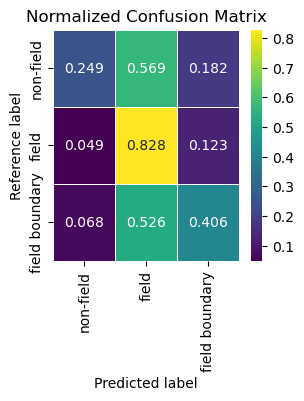

Train ▸ loss 0.6727  acc 0.611  |  Val ▸ loss 0.7373  acc 0.499  |  OA 0.499  mIoU 0.275
  ↳ new best model saved

— Epoch 2/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:30<00:00, 13.78it/s]
                                                                                                                

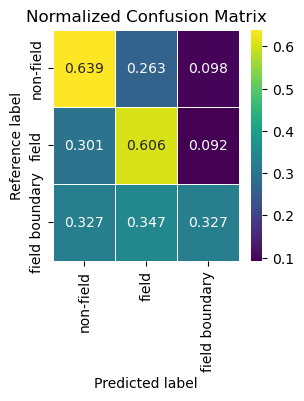

Train ▸ loss 0.6532  acc 0.634  |  Val ▸ loss 0.7194  acc 0.605  |  OA 0.605  mIoU 0.358
  ↳ new best model saved

— Epoch 3/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.40it/s]
                                                                                                                

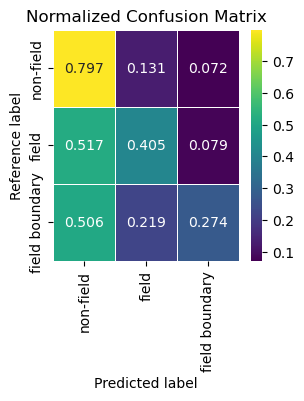

Train ▸ loss 0.6470  acc 0.643  |  Val ▸ loss 0.7424  acc 0.600  |  OA 0.600  mIoU 0.337
  ↳ early-stopping counter: 1/10

— Epoch 4/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.81it/s]
                                                                                                                

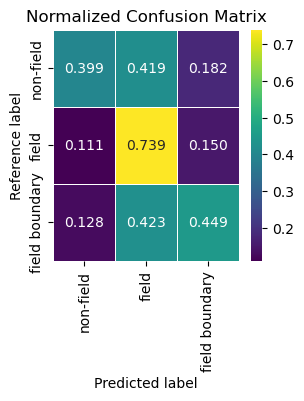

Train ▸ loss 0.6442  acc 0.647  |  Val ▸ loss 0.7173  acc 0.543  |  OA 0.543  mIoU 0.319
  ↳ new best model saved

— Epoch 5/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:19<00:00, 22.03it/s]
                                                                                                                

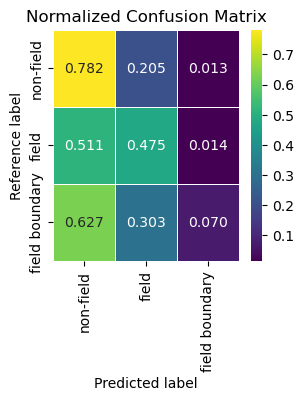

Train ▸ loss 0.6417  acc 0.652  |  Val ▸ loss 0.8349  acc 0.608  |  OA 0.608  mIoU 0.316
  ↳ early-stopping counter: 1/10

— Epoch 6/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 23.64it/s]
                                                                                                                

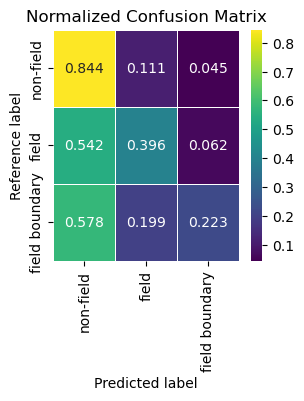

Train ▸ loss 0.6390  acc 0.657  |  Val ▸ loss 0.7557  acc 0.618  |  OA 0.618  mIoU 0.342
  ↳ early-stopping counter: 2/10

— Epoch 7/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:31<00:00, 13.34it/s]
                                                                                                                

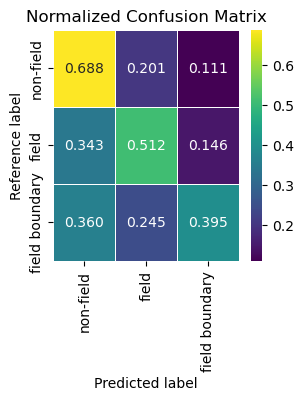

Train ▸ loss 0.6379  acc 0.657  |  Val ▸ loss 0.7117  acc 0.596  |  OA 0.596  mIoU 0.354
  ↳ new best model saved

— Epoch 8/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:18<00:00, 22.50it/s]
                                                                                                                

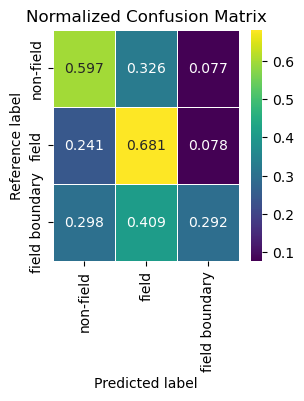

Train ▸ loss 0.6365  acc 0.660  |  Val ▸ loss 0.7236  acc 0.611  |  OA 0.611  mIoU 0.362
  ↳ early-stopping counter: 1/10

— Epoch 9/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:18<00:00, 22.95it/s]
                                                                                                                

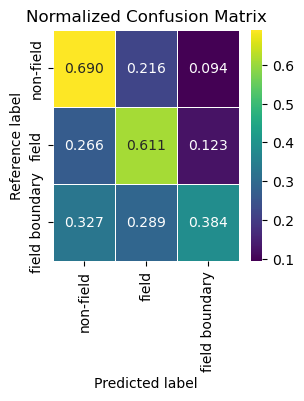

Train ▸ loss 0.6346  acc 0.664  |  Val ▸ loss 0.6940  acc 0.637  |  OA 0.637  mIoU 0.389
  ↳ new best model saved

— Epoch 10/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:18<00:00, 22.60it/s]
                                                                                                                

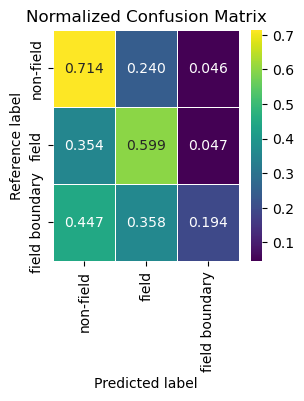

Train ▸ loss 0.6333  acc 0.667  |  Val ▸ loss 0.7585  acc 0.632  |  OA 0.632  mIoU 0.364
  ↳ early-stopping counter: 1/10

— Epoch 11/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:18<00:00, 22.98it/s]
                                                                                                                

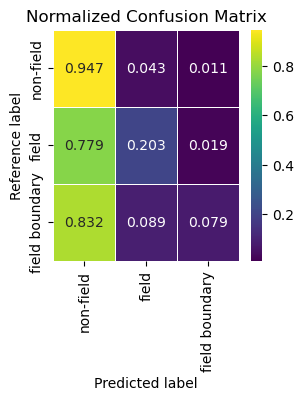

Train ▸ loss 0.6321  acc 0.667  |  Val ▸ loss 0.8490  acc 0.582  |  OA 0.582  mIoU 0.268
  ↳ early-stopping counter: 2/10

— Epoch 12/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:24<00:00, 16.99it/s]
                                                                                                                

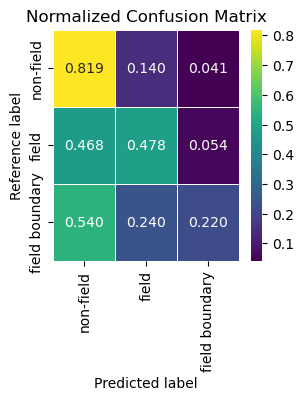

Train ▸ loss 0.6313  acc 0.670  |  Val ▸ loss 0.7470  acc 0.638  |  OA 0.638  mIoU 0.365
  ↳ early-stopping counter: 3/10

— Epoch 13/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:29<00:00, 14.07it/s]
                                                                                                                

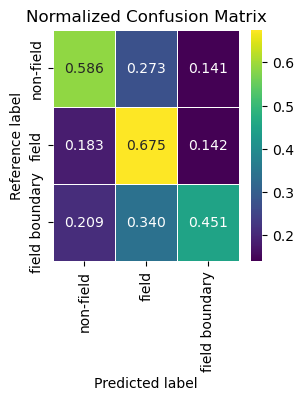

Train ▸ loss 0.6299  acc 0.672  |  Val ▸ loss 0.6886  acc 0.614  |  OA 0.614  mIoU 0.378
  ↳ new best model saved

— Epoch 14/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:18<00:00, 22.65it/s]
                                                                                                                

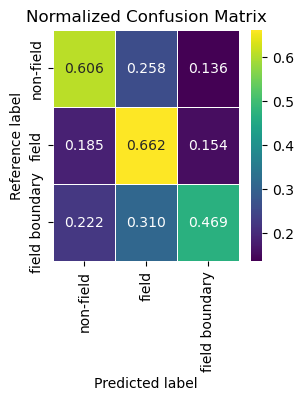

Train ▸ loss 0.6293  acc 0.673  |  Val ▸ loss 0.6818  acc 0.620  |  OA 0.620  mIoU 0.384
  ↳ new best model saved

— Epoch 15/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:18<00:00, 22.92it/s]
                                                                                                                

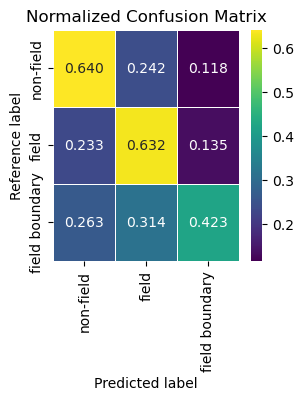

Train ▸ loss 0.6290  acc 0.674  |  Val ▸ loss 0.6901  acc 0.622  |  OA 0.622  mIoU 0.382
  ↳ early-stopping counter: 1/10

— Epoch 16/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:25<00:00, 16.28it/s]
                                                                                                                

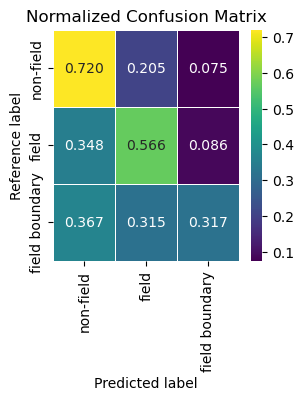

Train ▸ loss 0.6275  acc 0.675  |  Val ▸ loss 0.7121  acc 0.630  |  OA 0.630  mIoU 0.375
  ↳ early-stopping counter: 2/10

— Epoch 17/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.43it/s]
                                                                                                                

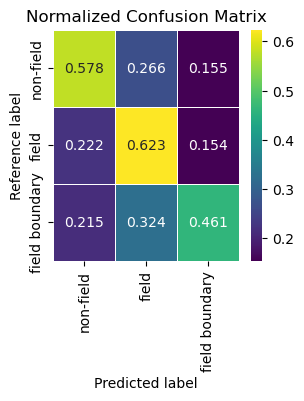

Train ▸ loss 0.6271  acc 0.676  |  Val ▸ loss 0.6983  acc 0.589  |  OA 0.589  mIoU 0.358
  ↳ early-stopping counter: 3/10

— Epoch 18/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.20it/s]
                                                                                                                

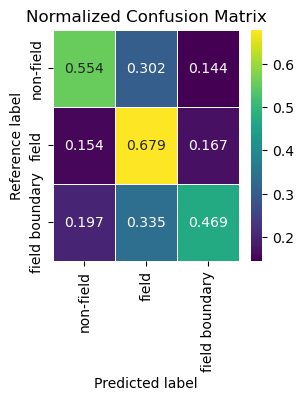

Train ▸ loss 0.6267  acc 0.676  |  Val ▸ loss 0.6914  acc 0.600  |  OA 0.600  mIoU 0.368
  ↳ early-stopping counter: 4/10

— Epoch 19/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.04it/s]
                                                                                                                

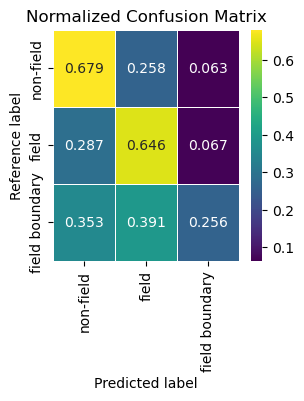

Train ▸ loss 0.6257  acc 0.678  |  Val ▸ loss 0.7313  acc 0.637  |  OA 0.637  mIoU 0.377
  ↳ early-stopping counter: 5/10

— Epoch 20/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.20it/s]
                                                                                                                

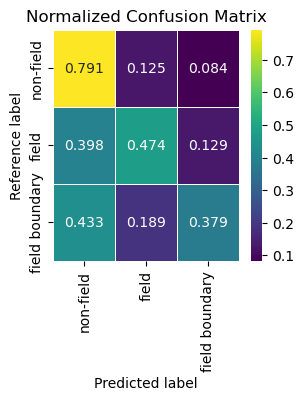

Train ▸ loss 0.6247  acc 0.680  |  Val ▸ loss 0.6994  acc 0.633  |  OA 0.633  mIoU 0.377
  ↳ early-stopping counter: 6/10

— Epoch 21/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:18<00:00, 22.74it/s]
                                                                                                                

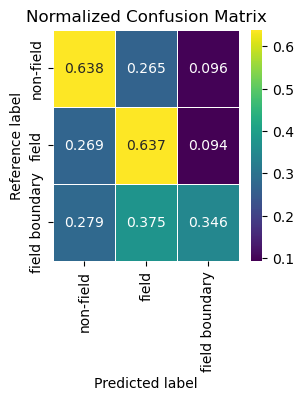

Train ▸ loss 0.6244  acc 0.681  |  Val ▸ loss 0.7071  acc 0.618  |  OA 0.618  mIoU 0.372
  ↳ early-stopping counter: 7/10

— Epoch 22/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:19<00:00, 21.67it/s]
                                                                                                                

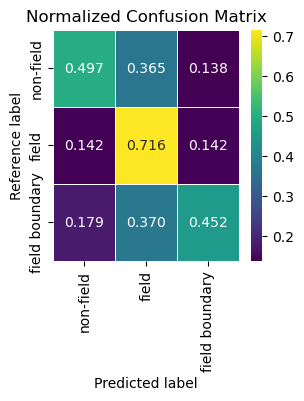

Train ▸ loss 0.6239  acc 0.682  |  Val ▸ loss 0.6934  acc 0.585  |  OA 0.585  mIoU 0.354
  ↳ early-stopping counter: 8/10

— Epoch 23/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:19<00:00, 21.38it/s]
                                                                                                                

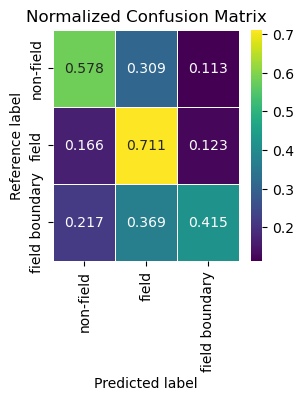

Train ▸ loss 0.6225  acc 0.684  |  Val ▸ loss 0.6874  acc 0.622  |  OA 0.622  mIoU 0.382
  ↳ early-stopping counter: 9/10

— Epoch 24/50 —


Validating: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:27<00:00, 15.36it/s]
                                                                                                                

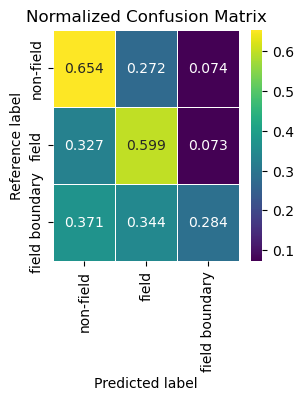

Train ▸ loss 0.6211  acc 0.687  |  Val ▸ loss 0.7288  acc 0.607  |  OA 0.607  mIoU 0.356
  ↳ early-stopping counter: 10/10
Early stopping triggered.
✓ training complete – metrics saved.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os
import pandas as pd
import numpy as np


import segmentation_models_pytorch as smp
from src.lacuna.evaluate import evaluate
from src.lacuna.datatorch import ImageData
from src.lacuna.losses import tversky_focal

# ---------------------------------------------------------------------
# 2.  Training loop
# ---------------------------------------------------------------------
criterion  = tversky_focal.LocallyWeightedTverskyFocalLoss()
optimizer  = optim.Adam(model.parameters(), lr=params_train["learning_rate_init"])
scheduler  = ReduceLROnPlateau(optimizer, mode="min", patience=10, verbose=True)

num_epochs            = params_train["epoch"]
early_stopping_pat    = params_train.get("early_stopping_patience", 10)
checkpoint_dir        = params_train.get("model_out_dir", "./checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_loss   = float("inf")
es_counter      = 0
records         = []

for epoch in range(1, num_epochs + 1):
    print(f"\n— Epoch {epoch}/{num_epochs} —")

    # ------------------ training phase ------------------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels, _mask in tqdm(train_dataloader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total   += labels.numel()

    train_loss = running_loss / len(train_dataloader.dataset)
    train_acc  = correct / total

    # ------------------ validation phase ------------------
    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_dataloader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * imgs.size(0)

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.numel()

    val_loss = running_val_loss / len(val_dataloader.dataset)
    val_acc  = correct / total
    scheduler.step(val_loss)

    # full-set semantic metrics (mIoU, F1, …)
    eval_metrics = evaluate_dataloader(
        model          = model,
        dataloader     = val_dataloader,
        num_classes    = 3,
        class_mapping  = params_train["class_mapping"],
        device         = device,
        buffer         = params_train.get("buffer", None),
        out_name       = os.path.join(checkpoint_dir, f"epoch{epoch}_metrics.csv")
    )

    # ------------------ logging ------------------
    records.append({
        "epoch":            epoch,
        "train_loss":       train_loss,
        "val_loss":         val_loss,
        "train_acc":        train_acc,
        "val_acc":          val_acc,
        "overall_accuracy": eval_metrics["Overall Accuracy"],
        "mean_accuracy":    eval_metrics["Mean Accuracy"],
        "mean_iou":         eval_metrics["Mean IoU"],
        "mean_precision":   eval_metrics["Mean Precision"],
        "mean_recall":      eval_metrics["Mean Recall"],
        "mean_f1_score":    eval_metrics["Mean F1 Score"],
    })

    print(f"Train ▸ loss {train_loss:.4f}  acc {train_acc:.3f}  |  "
          f"Val ▸ loss {val_loss:.4f}  acc {val_acc:.3f}  |  "
          f"OA {eval_metrics['Overall Accuracy']:.3f}  mIoU {eval_metrics['Mean IoU']:.3f}")

    # ------------------ checkpointing ------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        es_counter = 0
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pth"))
        print("  ↳ new best model saved")
    else:
        es_counter += 1
        print(f"  ↳ early-stopping counter: {es_counter}/{early_stopping_pat}")

    if es_counter >= early_stopping_pat:
        print("Early stopping triggered.")
        break

# ---------------------------------------------------------------------
# 3.  Persist the log
# ---------------------------------------------------------------------
pd.DataFrame(records).to_csv(os.path.join(checkpoint_dir, "training_metrics.csv"),
                             index=False)
print("✓ training complete – metrics saved.")


##### Finetuning ftw model on lacuna datasets

/home/airg/rbalogun/miniconda3/envs/ftw_fieldmapper/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



--- Epoch 1/50 ---


Validating: 100%|███████████████████████| 675/675 [00:34<00:00, 19.61it/s]


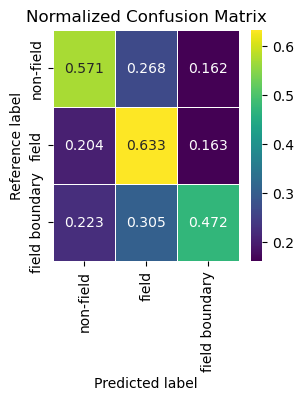

Train Loss: 0.6455 | Val Loss: 0.6986 | OA: 0.5899 | mIoU: 0.3600
  → New best model saved to ./checkpoints/best_model.pth

--- Epoch 2/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 35.83it/s]


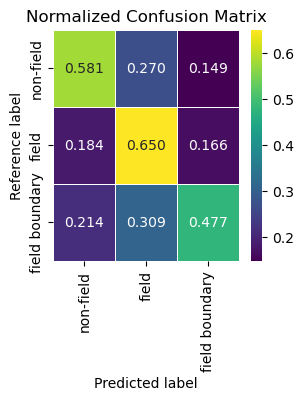

Train Loss: 0.6409 | Val Loss: 0.6908 | OA: 0.6029 | mIoU: 0.3709
  → New best model saved to ./checkpoints/best_model.pth

--- Epoch 3/50 ---


Validating: 100%|███████████████████████| 675/675 [00:17<00:00, 37.68it/s]


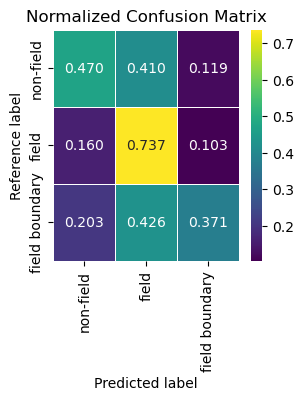

Train Loss: 0.6383 | Val Loss: 0.7158 | OA: 0.5740 | mIoU: 0.3390
  → Early stopping counter: 1/10

--- Epoch 4/50 ---


Validating: 100%|███████████████████████| 675/675 [00:17<00:00, 37.65it/s]


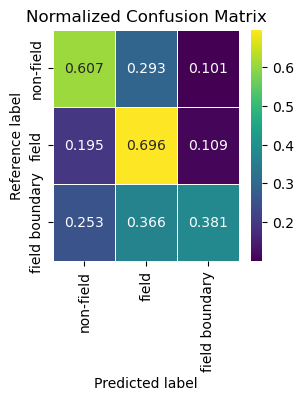

Train Loss: 0.6364 | Val Loss: 0.6947 | OA: 0.6284 | mIoU: 0.3842
  → Early stopping counter: 2/10

--- Epoch 5/50 ---


Validating: 100%|███████████████████████| 675/675 [00:17<00:00, 37.55it/s]


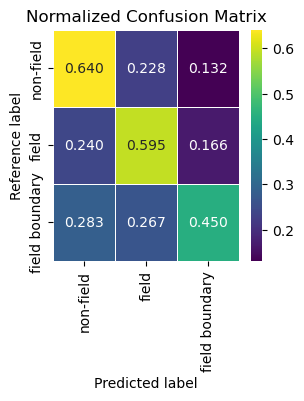

Train Loss: 0.6353 | Val Loss: 0.6956 | OA: 0.6088 | mIoU: 0.3721
  → Early stopping counter: 3/10

--- Epoch 6/50 ---


Validating: 100%|███████████████████████| 675/675 [00:17<00:00, 37.72it/s]


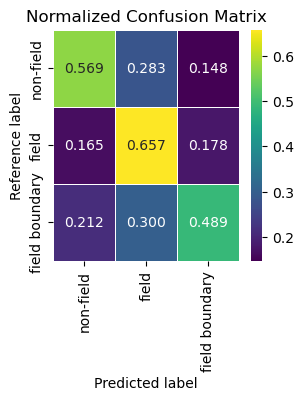

Train Loss: 0.6340 | Val Loss: 0.6897 | OA: 0.6000 | mIoU: 0.3695
  → New best model saved to ./checkpoints/best_model.pth

--- Epoch 7/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.49it/s]


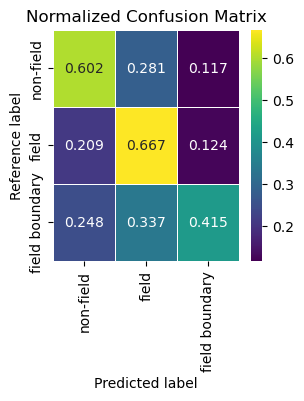

Train Loss: 0.6331 | Val Loss: 0.6920 | OA: 0.6165 | mIoU: 0.3770
  → Early stopping counter: 1/10

--- Epoch 8/50 ---


Validating: 100%|███████████████████████| 675/675 [00:17<00:00, 37.78it/s]


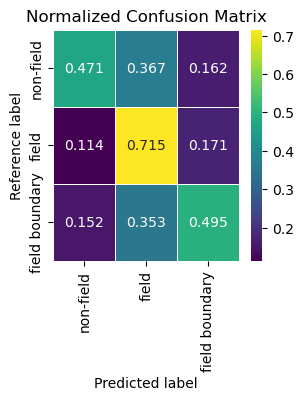

Train Loss: 0.6315 | Val Loss: 0.6952 | OA: 0.5733 | mIoU: 0.3478
  → Early stopping counter: 2/10

--- Epoch 9/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 36.57it/s]


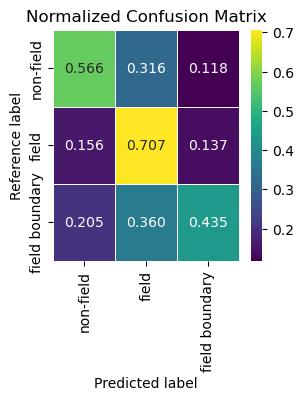

Train Loss: 0.6302 | Val Loss: 0.6874 | OA: 0.6157 | mIoU: 0.3783
  → New best model saved to ./checkpoints/best_model.pth

--- Epoch 10/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.14it/s]


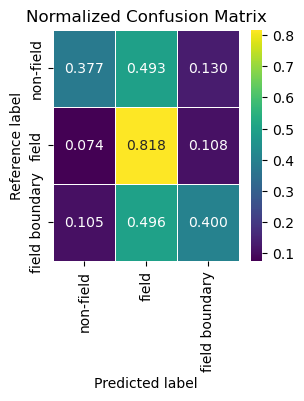

Train Loss: 0.6293 | Val Loss: 0.7110 | OA: 0.5608 | mIoU: 0.3271
  → Early stopping counter: 1/10

--- Epoch 11/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.27it/s]


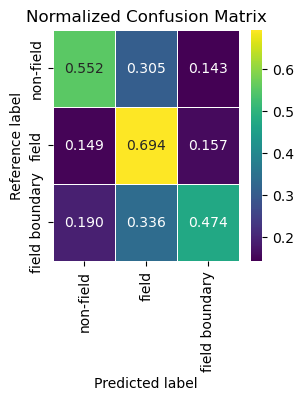

Train Loss: 0.6290 | Val Loss: 0.6879 | OA: 0.6053 | mIoU: 0.3727
  → Early stopping counter: 2/10

--- Epoch 12/50 ---


Validating: 100%|███████████████████████| 675/675 [00:27<00:00, 24.25it/s]


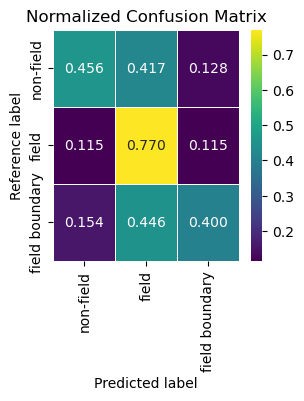

Train Loss: 0.6277 | Val Loss: 0.7066 | OA: 0.5819 | mIoU: 0.3466
  → Early stopping counter: 3/10

--- Epoch 13/50 ---


Validating: 100%|███████████████████████| 675/675 [00:25<00:00, 26.99it/s]


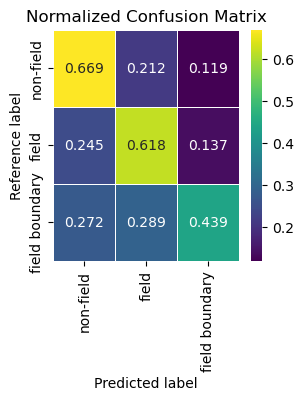

Train Loss: 0.6273 | Val Loss: 0.6839 | OA: 0.6327 | mIoU: 0.3909
  → New best model saved to ./checkpoints/best_model.pth

--- Epoch 14/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 36.92it/s]


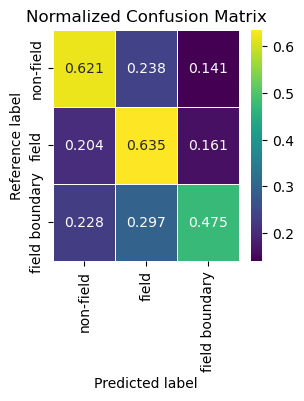

Train Loss: 0.6264 | Val Loss: 0.6855 | OA: 0.6169 | mIoU: 0.3816
  → Early stopping counter: 1/10

--- Epoch 15/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 35.62it/s]


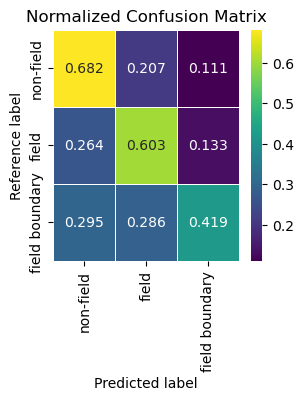

Train Loss: 0.6261 | Val Loss: 0.6890 | OA: 0.6317 | mIoU: 0.3878
  → Early stopping counter: 2/10

--- Epoch 16/50 ---


Validating: 100%|███████████████████████| 675/675 [00:20<00:00, 32.63it/s]


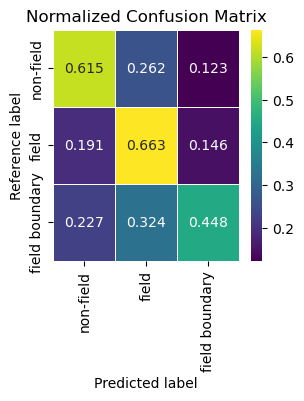

Train Loss: 0.6247 | Val Loss: 0.6844 | OA: 0.6238 | mIoU: 0.3857
  → Early stopping counter: 3/10

--- Epoch 17/50 ---


Validating: 100%|███████████████████████| 675/675 [00:19<00:00, 34.88it/s]


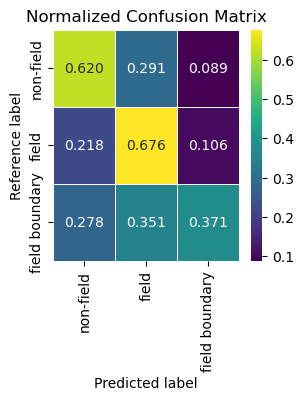

Train Loss: 0.6247 | Val Loss: 0.6958 | OA: 0.6266 | mIoU: 0.3818
  → Early stopping counter: 4/10

--- Epoch 18/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.10it/s]


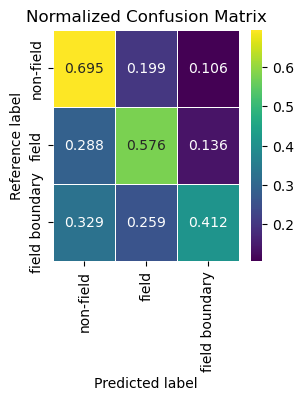

Train Loss: 0.6242 | Val Loss: 0.6941 | OA: 0.6269 | mIoU: 0.3821
  → Early stopping counter: 5/10

--- Epoch 19/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.23it/s]


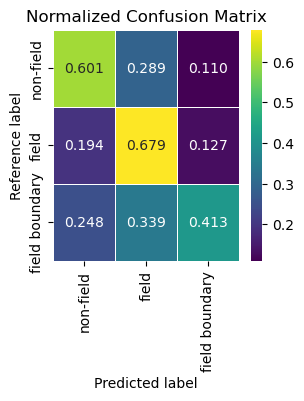

Train Loss: 0.6232 | Val Loss: 0.6909 | OA: 0.6208 | mIoU: 0.3805
  → Early stopping counter: 6/10

--- Epoch 20/50 ---


Validating: 100%|███████████████████████| 675/675 [00:21<00:00, 31.83it/s]


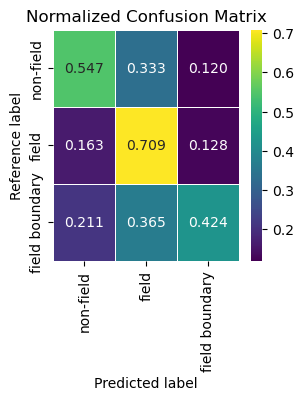

Train Loss: 0.6224 | Val Loss: 0.6922 | OA: 0.6056 | mIoU: 0.3691
  → Early stopping counter: 7/10

--- Epoch 21/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.12it/s]


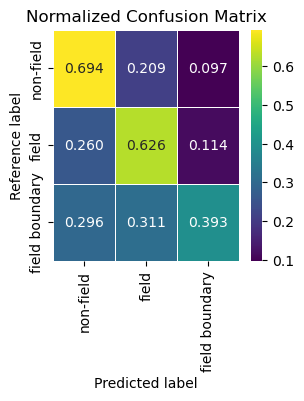

Train Loss: 0.6226 | Val Loss: 0.6879 | OA: 0.6459 | mIoU: 0.3979
  → Early stopping counter: 8/10

--- Epoch 22/50 ---


Validating: 100%|███████████████████████| 675/675 [00:20<00:00, 33.46it/s]


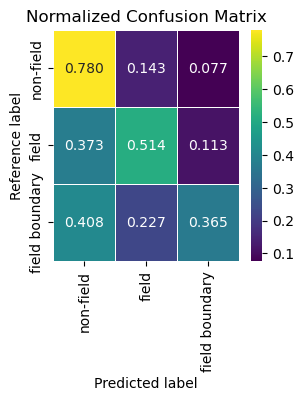

Train Loss: 0.6213 | Val Loss: 0.6975 | OA: 0.6426 | mIoU: 0.3865
  → Early stopping counter: 9/10

--- Epoch 23/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.35it/s]


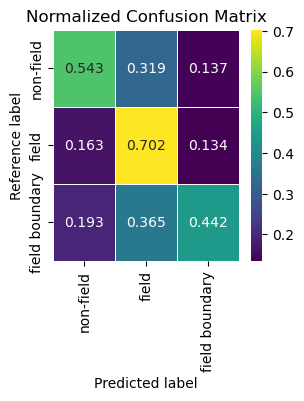

Train Loss: 0.6204 | Val Loss: 0.6941 | OA: 0.6022 | mIoU: 0.3677
  → Early stopping counter: 10/10
Early stopping triggered. Stopping training.

All training metrics saved to ./checkpoints/training_metrics.csv


In [8]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# from tqdm import tqdm
# import os
# import pandas as pd
# import numpy as np


# import segmentation_models_pytorch as smp
# from src.lacuna.evaluate import evaluate
# from src.lacuna.datatorch import ImageData
# from src.lacuna.losses import tversky_focal 


# # # Define loss (Dice Loss + CrossEntropy Loss)
# # class DiceCrossEntropyLoss(nn.Module):
# #     def __init__(self, weight_dice=0.5, weight_ce=0.5):
# #         super().__init__()
# #         self.dice_loss = smp.losses.DiceLoss(mode='multiclass')
# #         self.ce_loss = nn.CrossEntropyLoss()
# #         self.weight_dice = weight_dice
# #         self.weight_ce = weight_ce

# #     def forward(self, preds, targets):
# #         dice = self.dice_loss(preds, targets)
# #         ce = self.ce_loss(preds, targets)
# #         return self.weight_dice * dice + self.weight_ce * ce

# criterion = tversky_focal.LocallyWeightedTverskyFocalLoss()

# # Optimizer and Scheduler
# optimizer = optim.Adam(model.parameters(), lr=params_train["learning_rate_init"]) 
# # consider using the SAM Optimizer 
# scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=10, verbose=True)

# # Paths
# num_epochs = params_train["epoch"]
# early_stopping_patience = params_train.get("early_stopping_patience", 10)
# checkpoint_dir = params_train.get("model_out_dir/", "./checkpoints")
# metrics_log_file = os.path.join(checkpoint_dir, "training_metrics.csv")
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Class Mapping for evaluation
# class_mapping = params_train["class_mapping"]

# # Training
# best_val_loss = float("inf")
# early_stopping_counter = 0
# metrics_records = []

# for epoch in range(1, num_epochs + 1):
#     print(f"\n--- Epoch {epoch}/{num_epochs} ---")

#     model.train()
#     train_loss = 0.0

#     for imgs, labels, mask in tqdm(train_dataloader, desc="Training"):
#         imgs, labels, mask = imgs.to(device), labels.to(device), mask.to(device)

#         optimizer.zero_grad()
#         outputs = model(imgs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item() * imgs.size(0)

#     train_loss /= len(train_dataloader.dataset)

#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for imgs, labels in tqdm(val_dataloader, desc="Validating"):
#             # imgs, labels, mask = imgs.to(device), labels.to(device), mask.to(device)
#             imgs, labels = imgs.to(device), labels.to(device)

#             outputs = model(imgs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item() * imgs.size(0)

#     val_loss /= len(val_dataloader.dataset)
#     scheduler.step(val_loss)
    
#     evaluate(
#         model=model,
#         images, 
#         labels,
#         outputs,
#         num_classes=3,
#         class_mapping=class_mapping,
#         device=device,
#         buffer=params_train.get('buffer', None),
#         out_name=os.path.join(checkpoint_dir, f"epoch{epoch}_metrics.csv")
#     )

#     epoch_metrics = {
#         "epoch": epoch,
#         "train_loss": train_loss,
#         "val_loss": val_loss,
#         "overall_accuracy": eval_metrics["Overall Accuracy"],
#         "mean_accuracy": eval_metrics["Mean Accuracy"],
#         "mean_iou": eval_metrics["Mean IoU"],
#         "mean_precision": eval_metrics["mean Precision"],
#         "mean_recall": eval_metrics["mean Recall"],
#         "mean_f1_score": eval_metrics["Mean F1 Score"],
#     }
#     metrics_records.append(epoch_metrics)

#     print(
#         f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
#         f"OA: {eval_metrics['Overall Accuracy']:.4f} | mIoU: {eval_metrics['Mean IoU']:.4f}"
#     )

#     # Save best model
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         early_stopping_counter = 0
#         checkpoint_path = os.path.join(checkpoint_dir, f"best_model.pth")
#         torch.save(model.state_dict(), checkpoint_path)
#         print(f"  → New best model saved to {checkpoint_path}")
#     else:
#         early_stopping_counter += 1
#         print(f"  → Early stopping counter: {early_stopping_counter}/{early_stopping_patience}")

#     if early_stopping_counter >= early_stopping_patience:
#         print("Early stopping triggered. Stopping training.")
#         break

# # Save metrics
# metrics_df = pd.DataFrame(metrics_records)
# metrics_df.to_csv(metrics_log_file, index=False)
# print(f"\nAll training metrics saved to {metrics_log_file}")


#### Inference Pipeline

In [21]:
checkpoint_dir = "./checkpoints"
checkpoint_dir

'./checkpoints'

In [22]:
checkpoint_path = os.path.join('./checkpoints/', "best_model.pth")
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# ------------------------
# Load Test Data
# ------------------------
print("Loading test dataset...")
test_dataset = ImageData(
    data_path=params_train['data_path'],
    log_dir=params_train['log_dir'], 
    catalog=pd.read_csv(params_train['train_csv_name']).reset_index(drop=True),  
    data_size=params_train['data_size'],
    buffer=params_train['buffer'],
    buffer_comp=params_train['buffer_comp'],
    usage="test", 
    img_path_cols=params_train['img_path_cols'], 
    label_path_col=params_train['label_path_col'], 
    label_group=params_train['label_group'], 
    apply_normalization=params_train['apply_normalization'],
    normal_strategy=params_train['normal_strategy'],
    stat_procedure=params_train['stat_procedure'],
    global_stats=params_train['global_stats'],
    catalog_index=params_train['catalog_index'],
    trans=params_train['trans'],
    parallel=params_train['parallel'],
    scale_factor=params_train['scale_factor'],
    crop_strategy=params_train['crop_strategy'],
    rotation_degree=params_train['rotation_degree'],
    sigma_range=params_train['sigma_range'],
    br_range=params_train['br_range'],
    contrast_range=params_train['contrast_range'],
    bshift_gamma_range=params_train['bshift_gamma_range'],
    patch_shift=params_train['patch_shift'],
    downfactor=params_train['downfactor'],
    clip_val=params_train['clip_val'],
    nodata=params_train['nodata']
)

from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    test_dataset,
    batch_size=params_train["validate_batch"],
    shuffle=False
)

Loading test dataset...
type: <class 'numpy.ndarray'> shape/len: (224, 224, 4)
----------6748 samples loaded in test dataset-----------
Total number of samples in test dataset: 6748


Running inference on test dataset...


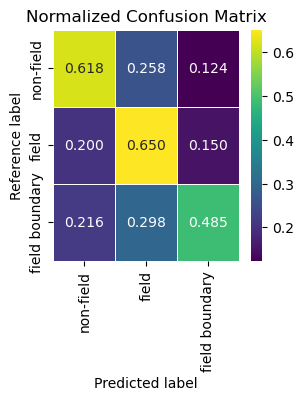


Test Metrics:
Overall Accuracy: 0.6209
Mean Accuracy: 0.5844
Mean IoU: 0.3655
mean Precision: 0.5083
mean Recall: 0.5844
Mean F1 Score: 0.5099


In [23]:
from src.lacuna.evaluate import evaluate
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Inference & Evaluation
print("Running inference on test dataset...")
class_mapping = params_train["class_mapping"]

metrics = evaluate(
    model=model,
    dataloader=test_dataloader,
    num_classes=3,
    class_mapping=class_mapping,
    device=device,
    buffer=params_test.get('buffer', None),
    out_name=os.path.join(checkpoint_dir, "test_metrics.csv")
)

# Print and save results
print("\nTest Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

metrics_df = pd.DataFrame([metrics])
os.makedirs(params_test.get("out_dir", "./test_results"), exist_ok=True)
metrics_df.to_csv(os.path.join(checkpoint_dir, "summary_metrics.csv"), index=False)

#### Visualize Predictions

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataloader, class_mapping, device, num_images=4, save_dir=None, fname_prefix = "pred"):
    """
    Visualizes predictions alongside ground truth for a few samples.
    
    Args:
        model (nn.Module): Trained segmentation model.
        dataloader (DataLoader): Validation/test DataLoader.
        class_mapping (dict): Mapping of class indices to names.
        device (torch.device): CPU or CUDA.
        num_images (int): Number of samples to visualize.
    """

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    cmap = plt.get_cmap("tab10")  # for consistent color mapping
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(min(num_images, images.shape[0])):
                img = images[i].cpu().numpy()
                label = labels[i].cpu().numpy()
                pred = preds[i].cpu().numpy()

                # If image has 4 channels, use RGB only for visualization
                img_disp = img[:3, :, :] if img.shape[0] >= 3 else img
                img_disp = np.moveaxis(img_disp, 0, -1)  # CxHxW -> HxWxC
                img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(img_disp)
                axes[0].set_title("Input Image")
                axes[0].axis('off')

                axes[1].imshow(label, cmap="tab10", vmin=0, vmax=len(class_mapping)-1)
                axes[1].set_title("Ground Truth")
                axes[1].axis('off')

                axes[2].imshow(pred, cmap="tab10", vmin=0, vmax=len(class_mapping)-1)
                axes[2].set_title("Prediction")
                axes[2].axis('off')

                plt.tight_layout()
                plt.show()

                if save_dir is not None:
                    fname = f"{fname_prefix}_{i}.png"
                    fig_path = os.path.join(save_dir, fname)
                    fig.savefig(fig_path, dpi=300, bbox_inches="tight")
                    plt.close(fig)  # free memory
                    print(f"Saved → {fig_path}")

            break  # Only first batch


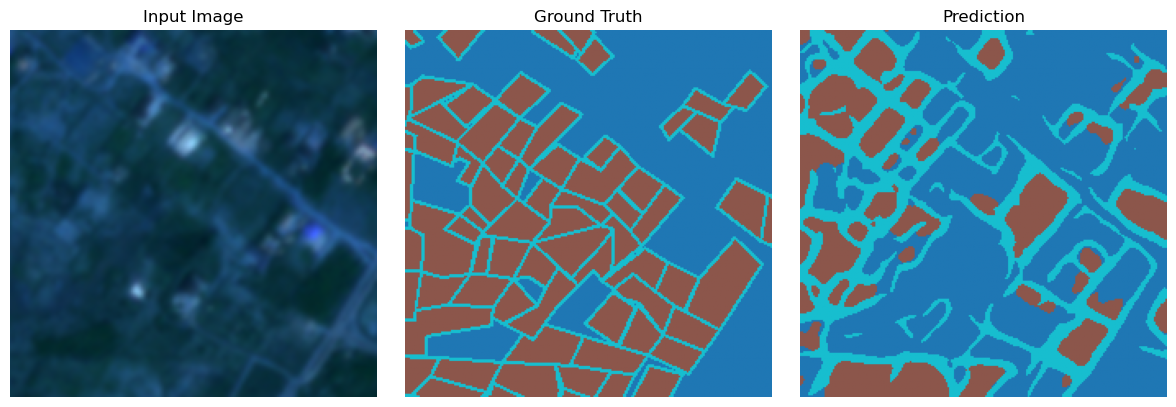

Saved → ./checkpoints/pred_0.png


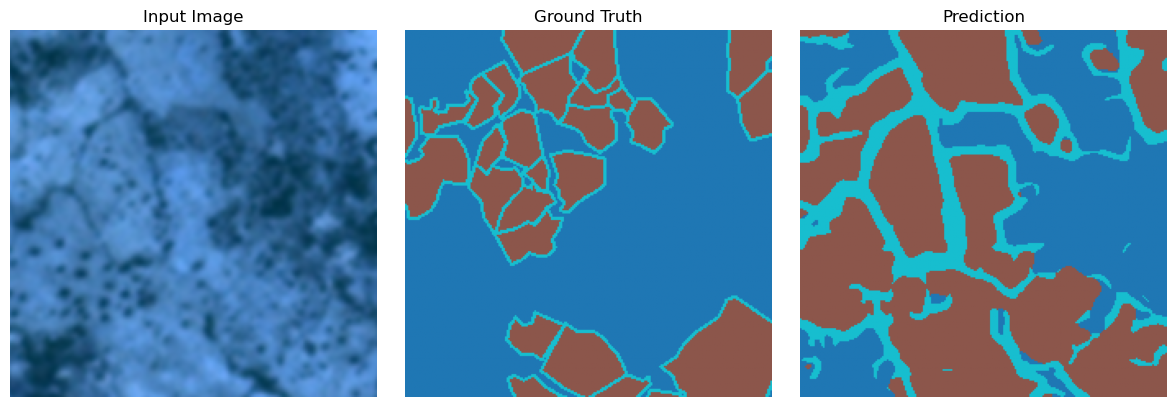

Saved → ./checkpoints/pred_1.png


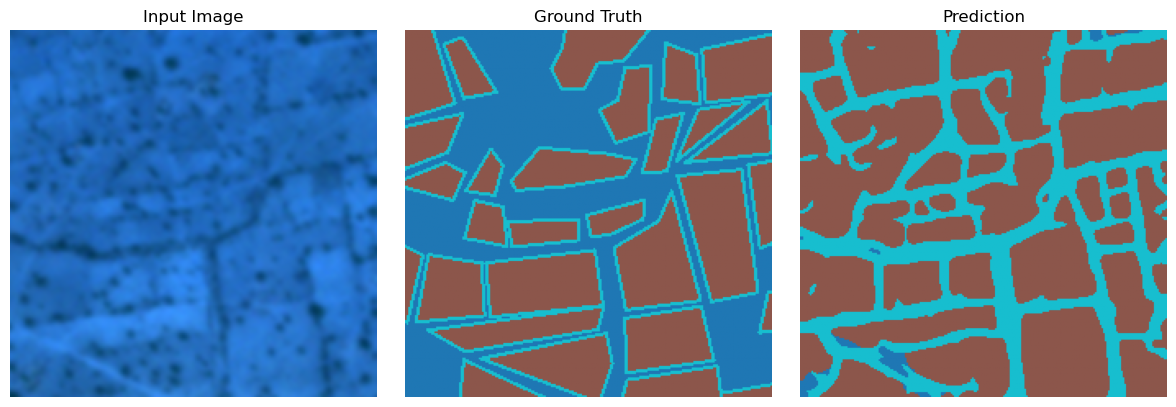

Saved → ./checkpoints/pred_2.png


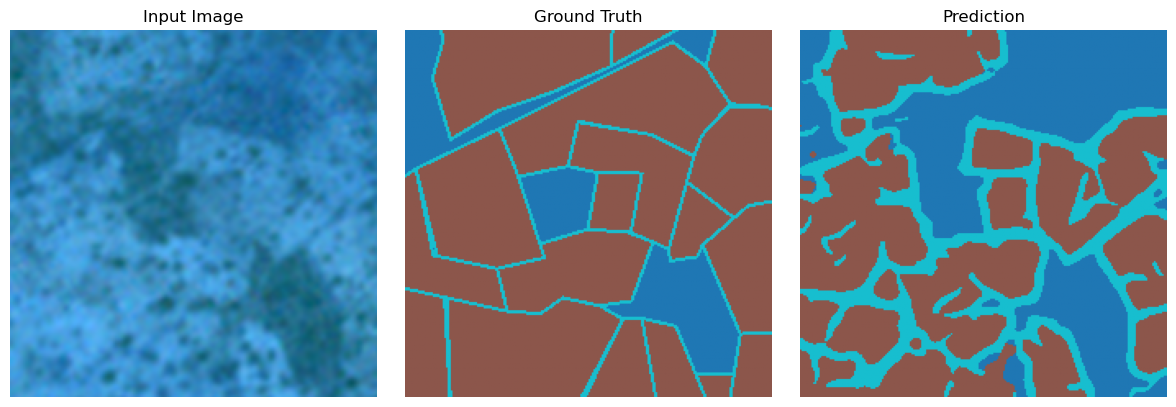

Saved → ./checkpoints/pred_3.png


In [28]:
class_mapping = params_train["class_mapping"]
visualize_predictions(
    model=model,
    dataloader=val_dataloader,
    class_mapping=class_mapping,
    device=device,
    num_images=4,
    save_dir=checkpoint_dir
)

In [29]:
import torch
torch.cuda.empty_cache()